# Strawberry Price Prediction - Exploratory Data Analysis

Objective : create a model that would predict the price of strawberries at a 2 weeks horizon, using past data to train the model and the 2022-2023 season data for testing.

With an internet search, the price of strawberries depend of :
* Supply: season, yield, weather, diseases
* Demand: consumption
* Others

This notebook explores the strawberry price prediction dataset, focusing on:
1. Data overview and missing values
2. Price distribution and trends
3. Weather features analysis
4. Seasonal patterns

SYNTHESE EDA :
data per week, seasonal patern important, missing prices for summer
the price has a gamma distribution

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from src.fct_eda import *
from src.parameter import get_dict_params

## 1. Load and Examine Data

In [13]:
# Load data
df = pd.read_csv('data/raw/senior_ds_test.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nSample Data:\n", df.head())

Dataset Shape: (521, 15)

Columns: ['Unnamed: 0', 'year', 'week', 'windspeed', 'temp', 'cloudcover', 'precip', 'solarradiation', 'start_date', 'end_date', 'category', 'unit', 'price_min', 'price_max', 'price']

Data Types:
 Unnamed: 0          int64
year                int64
week                int64
windspeed         float64
temp              float64
cloudcover        float64
precip            float64
solarradiation    float64
start_date         object
end_date           object
category           object
unit               object
price_min         float64
price_max         float64
price             float64
dtype: object

Sample Data:
    Unnamed: 0  year  week  windspeed       temp  cloudcover    precip  \
0           1  2013    28  21.900000  26.100000   13.500000  0.013000   
1           2  2013    29  24.185714  26.914286   10.242857  0.000000   
2           3  2013    30  21.728571  27.871429   13.785714  0.000000   
3           4  2013    31  22.971429  27.014286   18.900000  0.00

In [14]:
# Load of parameters
dict_params = get_dict_params()
weather_cols = dict_params['weather_cols']
test_start_year = dict_params['test_start_year']

## Onthology
Each row represents one week of observations, including weather conditions, solar radiation, and strawberry price ranges.

| Column Name      | Description                                                                                       |
| ---------------- | ------------------------------------------------------------------------------------------------- |
| `year`           | The calendar year of the observation.                                                             |
| `week`           | week number, corresponding to the weekly aggregation.                               |
| `windspeed`      | Average wind speed during the week (km/h or m/s). |
| `temp`           | Average air temperature during the week (°C).                                                     |
| `cloudcover`     | Average cloud cover during the week (%).                                                          |
| `precip`         | Total precipitation during the week (mm).                                                         |
| `solarradiation` | Average solar radiation during the week (W/m²).                                                   |
| `start_date`     | Start date of the week (YYYY-MM-DD).                                                              |
| `end_date`       | End date of the week (YYYY-MM-DD).                                                                |
| `category`       | Quality or classification category for the strawberries.                |
| `unit`           | Pricing unit, e.g. "Euros/kg".                                                                    |
| `price_min`      | Minimum observed price during the week.                                   |
| `price_max`      | Maximum observed price during the week.                                   |
| `price`          | Average price during the week.                          |


## Database metadata
This dataset combines weekly strawberry market prices with meteorological data for a specific region. It is aggregated data.

In [15]:
# Correcting types date
for col in [x for x in df.columns if 'date' in x]:
    df[col] = pd.to_datetime(df[col])

## 2. Missing Values Analysis

Missing Values Count:

Unnamed: 0          0
year                0
week                0
windspeed           0
temp                0
cloudcover          0
precip              0
solarradiation      0
start_date        242
end_date          242
category          242
unit              242
price_min         242
price_max         242
price             242
dtype: int64


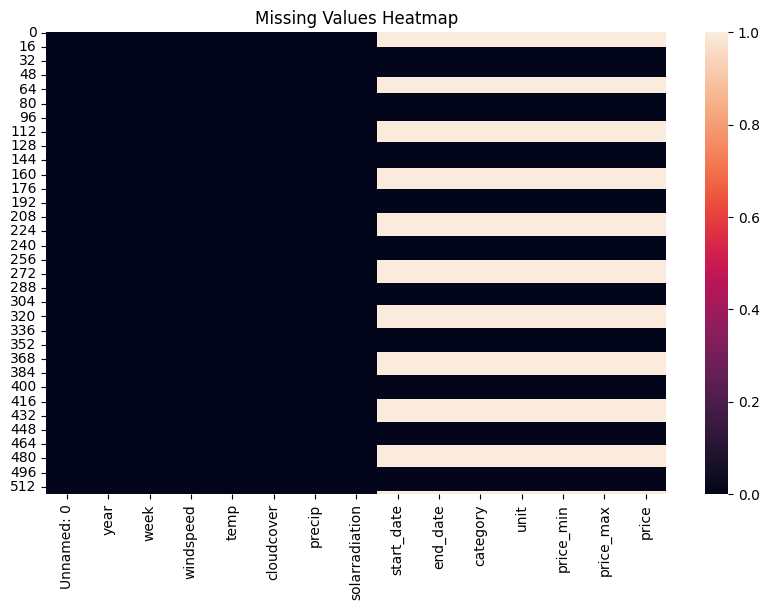

In [16]:
# Check missing values
print("Missing Values Count:\n")
print(df.isnull().sum())

# Plot missing values heatmap
plot_missing_values(df)

Obs : the missing data are not random. It seems that this dataframe comes from a merging of a weather database and a price database. I think the price was not present for some weeks.

In [17]:
# Exploration of the missing data.
df.iloc[255:260]

,Unnamed: 0,year,week,windspeed,temp,cloudcover,precip,solarradiation,start_date,end_date,category,unit,price_min,price_max,price
255,256,2018,22,20.357143,22.128571,40.157143,2.322143,270.014286,2018-05-28,2018-06-03,I,Euros/kg,0.82,0.82,0.82
256,257,2018,23,19.642857,22.671429,48.657143,1.330714,255.814286,2018-06-04,2018-06-10,I,Euros/kg,0.84,0.84,0.84
257,258,2018,24,19.585714,24.985714,15.857143,0.000000,319.028571,NaT,NaT,NaN,NaN,NaN,NaN,NaN
258,259,2018,25,20.014286,26.014286,4.771429,0.000000,318.342857,NaT,NaT,NaN,NaN,NaN,NaN,NaN
259,260,2018,26,19.157143,26.800000,19.571429,0.002000,293.514286,NaT,NaT,NaN,NaN,NaN,NaN,NaN


/home/briacleguillou/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/strawberries-price-prediction-RFzSQChC-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/briacleguillou/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/strawberries-price-prediction-RFzSQChC-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


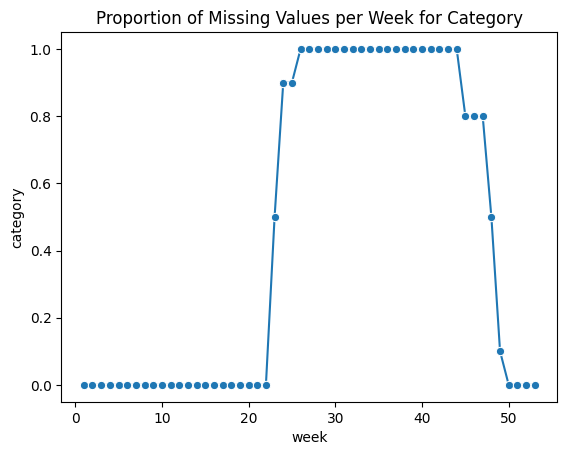

In [18]:
df_week_mv = df.loc[:,['week', 'category']].set_index('week').isna().groupby('week').mean()

# Graphic
sns.lineplot(data=df_week_mv, x='week', y='category', marker='o', color='tab:blue')
plt.title('Proportion of Missing Values per Week for Category')
plt.show()

Obs : From the week 24 to 49, the prices are missing in the database.

/home/briacleguillou/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/strawberries-price-prediction-RFzSQChC-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/briacleguillou/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/strawberries-price-prediction-RFzSQChC-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/briacleguillou/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/strawberries-price-prediction-RFzSQChC-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remo

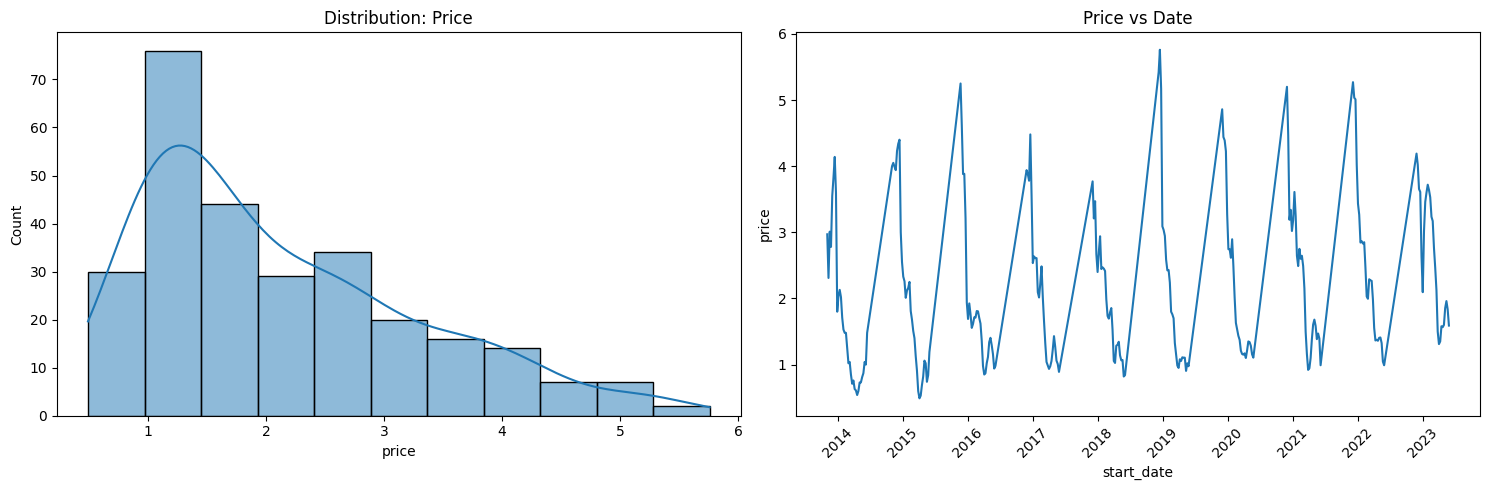


Price Statistics (Training Set):
count    279.000000
mean       2.118728
std        1.160889
min        0.490000
25%        1.160000
50%        1.760000
75%        2.805000
max        5.760000
Name: price, dtype: float64


In [19]:
# Plot price distribution and time series
plot_price_distribution(df)

# Basic statistics
print("\nPrice Statistics (Training Set):")
print(df['price'].describe())

Obs : the price distribution seems to be a gamma distribution, skewed to the left (low price).

## 5. Weather Features Analysis

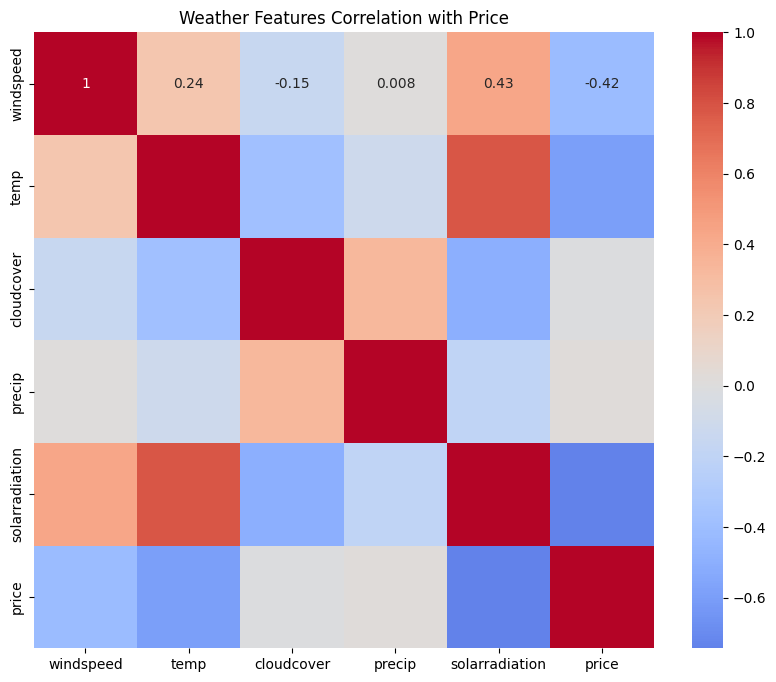


Weather Features Statistics (Training Set):
        windspeed        temp  cloudcover      precip  solarradiation  \
count  521.000000  521.000000  521.000000  521.000000      521.000000   
mean    18.678273   19.304524   37.131187    0.860611      204.643927   
std      4.311509    6.263942   14.614186    2.520322       80.698016   
min      7.271429    6.428571    2.985714    0.000000       57.085714   
25%     16.028571   13.557143   26.500000    0.000000      128.900000   
50%     18.885714   18.900000   37.385714    0.022429      198.514286   
75%     20.942857   24.742857   47.242857    0.572714      278.514286   
max     36.728571   32.100000   92.700000   33.919857      358.571429   

            price  
count  279.000000  
mean     2.118728  
std      1.160889  
min      0.490000  
25%      1.160000  
50%      1.760000  
75%      2.805000  
max      5.760000  


In [20]:
# Plot correlations
plot_weather_correlations(df)
# TODO  try to correct the vizualisation with annot

# Weather features statistics
print("\nWeather Features Statistics (Training Set):")
print(df[weather_cols].describe())

Obs : the solar radiation and temperature seem to be correlated the prices.

## 6. Seasonal Patterns

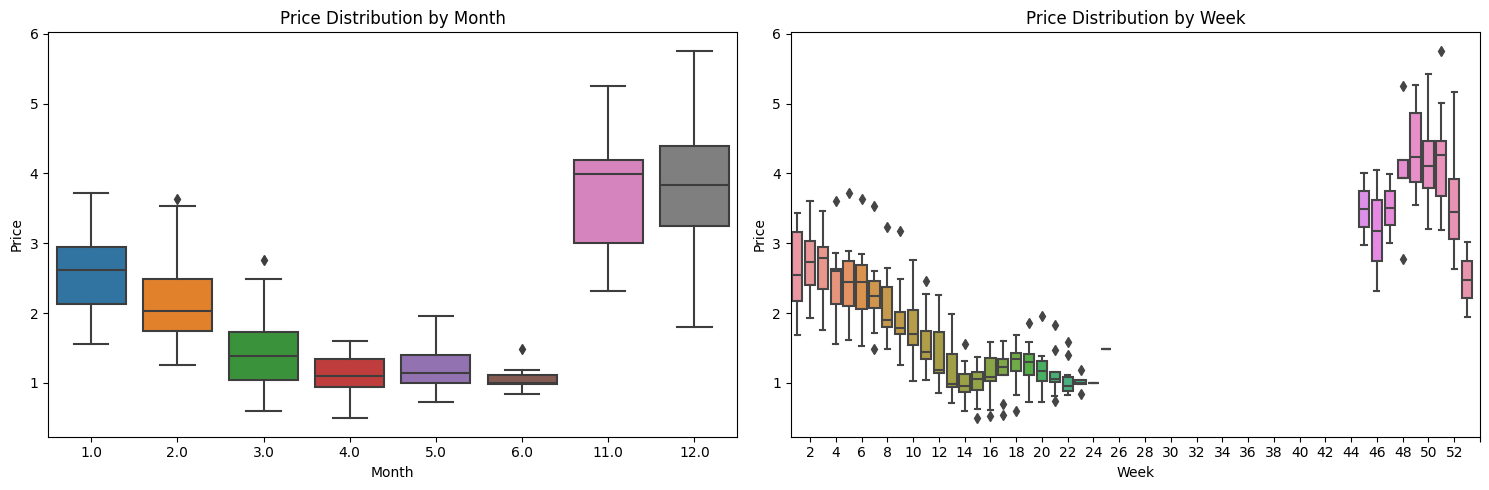


Average Price by Year:
year
2013    3.273750
2014    1.842727
2015    1.892414
2016    1.852321
2017    1.892308
2018    2.142500
2019    2.103654
2020    2.118704
2021    2.380370
2022    2.345741
2023    2.407727
Name: price, dtype: float64


In [21]:
# Plot seasonal patterns
plot_seasonal_patterns(df)

# Additional seasonal analysis
print("\nAverage Price by Year:")
print(df.groupby('year')['price'].mean())

Obs : At the end of the year, the price range is important, and the price is high. The prices seem to decrease until April.

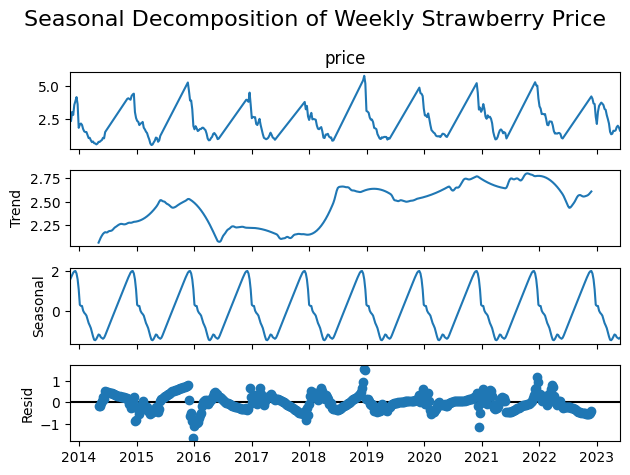

In [22]:
seasonal_analysis_weekly(df)


Obs : We observe a high saisonality compare to the trend. The trend is not linear.